In [1]:
import time

In [14]:
import sys
import time
import threading

class Spinner:
    busy = False
    delay = 0.1

    @staticmethod
    def spinning_cursor():      
        while 1: 
            for cursor in '|/-\\': yield cursor

    def __init__(self, delay=None):
        self.spinner_generator = self.spinning_cursor()
        if delay and float(delay): self.delay = delay

    def spinner_task(self):
        while self.busy:
            sys.stdout.write(next(self.spinner_generator))
            sys.stdout.flush()
            time.sleep(self.delay)
            sys.stdout.write('\b')
            sys.stdout.flush()

    def __enter__(self):
        self.busy = True
        threading.Thread(target=self.spinner_task).start()

    def __exit__(self, exception, value, tb):
        self.busy = False
        time.sleep(self.delay)
        if exception is not None:
            return False

In [15]:
with Spinner():
    time.sleep(3)

In [1]:
%run init_notebookspace.py
from settings import DATA_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
import pymc3 as pm
import pytensor.tensor as tt
import pytensor

import numpy as np

import matplotlib.pyplot as plt
from config import plt_config
plt.rcParams.update(plt_config)

import statsmodels.api as sm



from src.plotting import plot_dfs
from src.process_data import load_data

from pytensor.compile.mode import get_mode


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# get data

In [4]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_c', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_s': 'pi'})

# split train and test
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


In [5]:
# get GDP data

<Axes: xlabel='date'>

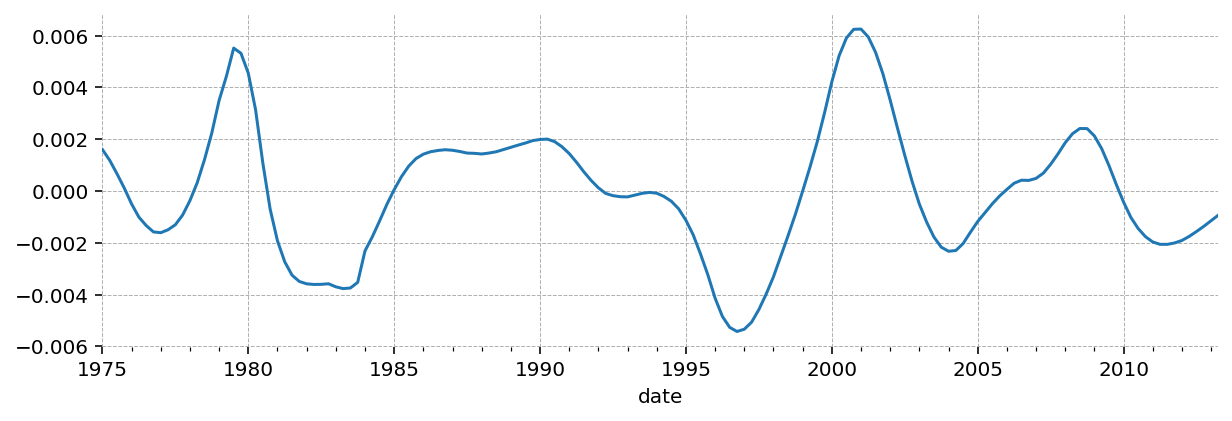

In [6]:
data = train['Y'].copy()
data.plot()

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

C:\Users\LukasGrahl\miniconda3\envs\env_conda_memoire1\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


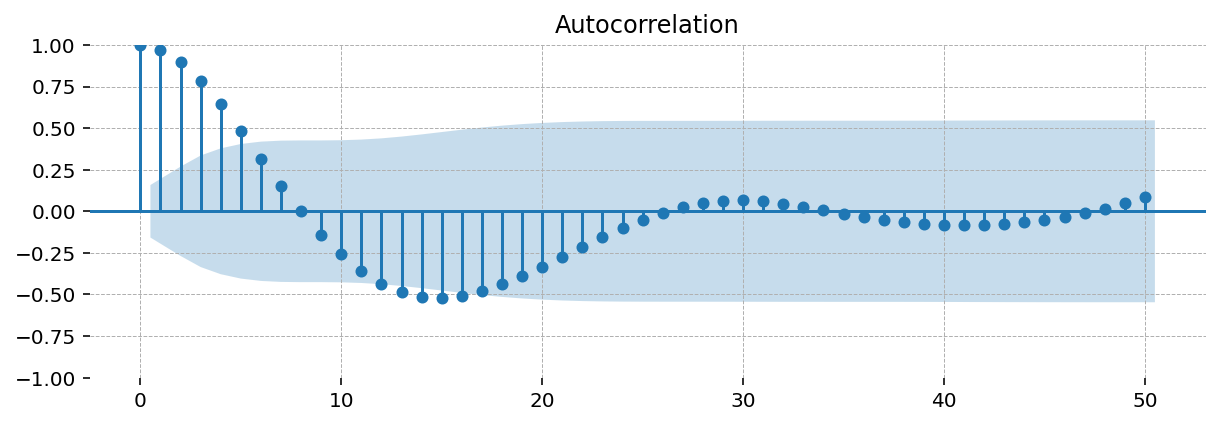

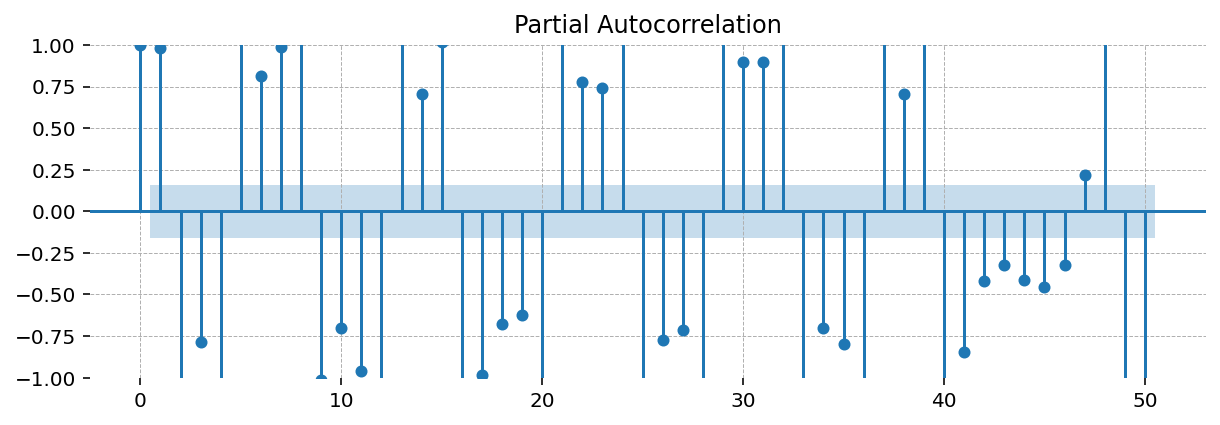

In [8]:
plot_acf(data, lags=50);
plot_pacf(data, lags=50);

In [9]:
# SARIMAX
mod = sm.tsa.statespace.SARIMAX(data, order=(5, 0, 3))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  154
Model:               SARIMAX(5, 0, 3)   Log Likelihood                1121.242
Date:                Tue, 25 Apr 2023   AIC                          -2224.484
Time:                        09:44:46   BIC                          -2197.152
Sample:                    01-01-1975   HQIC                         -2213.382
                         - 04-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9685      0.007    295.299      0.000       1.955       1.982
ar.L2         -1.1524      0.004   -323.798      0.000      -1.159      -1.145
ar.L3         -0.0604      0.002    -35.114      0.0

C:\Users\LukasGrahl\miniconda3\envs\env_conda_memoire1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


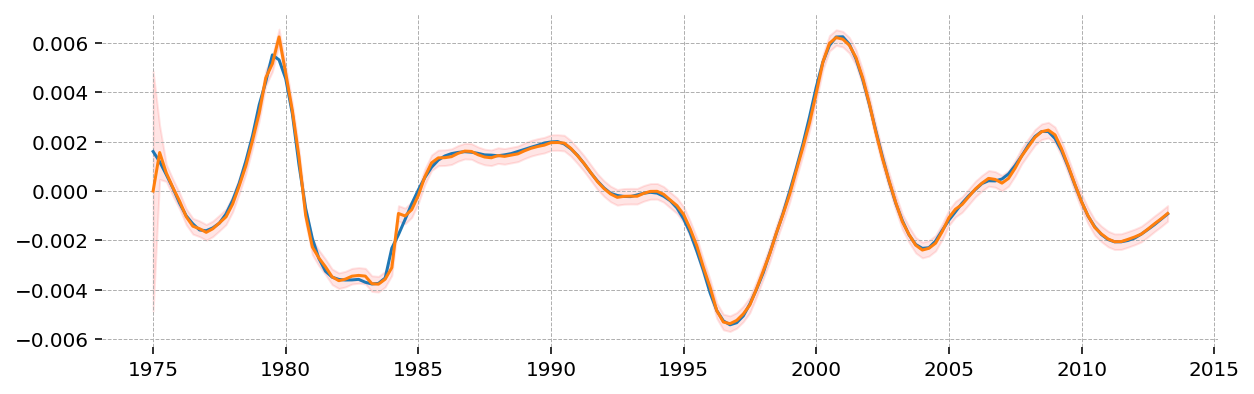

In [10]:
predicted = res_mle.get_prediction()
conf = predicted.conf_int()
lower = conf["lower Y"]
upper = conf["upper Y"]

plt.plot(data)
plt.plot(res_mle.predict())
plt.fill_between(conf.index, lower, upper, color="r", alpha=0.1)

In [11]:
# statsmodels wrapper

In [16]:
# new copy
class Loglike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        outputs[0][0] = self.model.score(theta)

In [12]:
class Loglike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        outputs[0][0] = self.model.score(theta)

In [13]:
# building the bayesian model

In [14]:
ndraws = 3_000
nburn = 600

In [15]:
loglike = Loglike(mod)

with pm.Model() as m:
    # Priors
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)
    maL1 = pm.Uniform("ma.L1", -0.99, 0.99)
    sigma2 = pm.InverseGamma("sigma2", 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    # pm.DensityDist("likelihood", logp=loglike, observed=theta)
    pm.DensityDist('likelihood', logp=loglike) #tt.as_tensor_variable([np.random.randn(1),np.random.randn(1),np.random.randn(1)]),)
    
    # Draw samples
    # trace = pm.sample(
    #     ndraws,
    #     tune=nburn,
    #     return_inferencedata=True,
    #     cores=1,
    #     compute_convergence_checks=False,
    # )

TypeError: Unsupported dtype for TensorType: object

In [17]:
# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. Here we are using the same model instance
# created earlier for MLE analysis (we could also create a new model
# instance if we preferred)
loglike = Loglike(mod)

with pm.Model() as m:
    # Priors
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)
    maL1 = pm.Uniform("ma.L1", -0.99, 0.99)
    sigma2 = pm.InverseGamma("sigma2", 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike, observed=theta)

    # Draw samples
    trace = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

TypeError: Unsupported dtype for TensorType: object

In [77]:
### pymc arma

In [90]:
lags = 2
trials = 100

coords = {
    "lags": range(-lags, 0),
    "steps": range(trials - lags),
    "trials": range(trials),
}
with pm.Model(coords=coords, check_bounds=False) as m:
    rho = pm.Normal("rho", 0, 0.2, dims=("lags",))
    sigma = pm.HalfNormal("sigma", .2)
    
    ar_init_obs = pm.MutableData("ar_init_obs", np.full((lags,), np.nan), dims=("lags",))
    ar_init = pm.Normal("ar_init", observed=ar_init_obs, dims=("lags",))

    def ar_step(*args):
        x_tm2, x_tm1, rho, sigma = args
        mu = x_tm1 * rho[0] + x_tm2 * rho[1]
        x = mu + pm.Normal.dist(sigma=sigma)
        return x, collect_default_updates(args, [x])
    
    ar_innov, ar_innov_updates = pytensor.scan(
        fn=ar_step,
        outputs_info=[{"initial": ar_init, "taps":range(-lags, 0)}],
        non_sequences=[rho, sigma],
        n_steps=trials-lags,
        strict=True,
    )

    ar_innov_obs = pm.MutableData("ar_innov_obs", np.full((trials-lags,), np.nan), dims=("steps",))
    ar_innov = m.register_rv(ar_innov, name="ar_innov", observed=ar_innov_obs, dims=("steps"))
    
    ar = pm.Deterministic("ar", pt.concatenate([ar_init, ar_innov], axis=-1), dims=("trials",))

NotImplementedError: MaskedArrays are not supported

In [78]:
### pymc example

In [79]:
J = 8
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])

In [80]:
with pm.Model() as pooled:
    mu = pm.Normal("mu", 0, sigma=1e6)

    obs = pm.Normal("obs", mu, sigma=sigma, observed=y)

    trace_p = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


In [81]:
pooled

 mu ~ Normal(0, 1e+06)
obs ~ Normal(mu, <constant>)

In [82]:
trace_p

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data